In [1]:
import torch
from torch import pi
from matplotlib import pyplot as plt

**Heat equation:**

$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

- Boundary Conditions (for all $t \geq 0$.): 
    - $u(0, t) = 0$
    - $u(1, t) = 0$
- Initial Condition:
    - $u(x, 0) = \sin(\pi x)$ for $0 \leq x \leq 1$.

**Analytical solution:**

$u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x)$

In [2]:
def u(x, t, alpha):
    return torch.exp(-alpha * (pi**2) * t) * torch.sin(pi * x)


def du_dt(x, t, alpha):
    return -(alpha * pi**2) * torch.exp(-alpha * t * pi**2) * torch.sin(pi * x)


def d2u_dx2(x, t, alpha):
    return -(pi**2) * torch.exp(-alpha * t * pi**2) * torch.sin(pi * x)

In [3]:
n_x = 100
n_t = 100
max_t = 100
alpha = 4 * 1e-8

features, t = (
    torch.linspace(start=0, end=1, steps=n_x),
    torch.linspace(start=0, end=max_t, steps=n_t),
)
xx, tt = torch.meshgrid(features, t)
y = u(xx, tt, alpha)

dataset = torch.utils.data.TensorDataset(
    # torch.vstack((xx.flatten(),tt.flatten())).T.requires_grad_(),
    xx.flatten().requires_grad_(),
    tt.flatten().requires_grad_(),
    y.flatten().unsqueeze(1),
)

/home/andre/anaconda3/envs/hc-dev/lib/python3.12/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4381.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [35]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1),
)

In [36]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [37]:
constraints = [
    lambda _, t: torch.nn.functional.mse_loss(
        model(torch.vstack((torch.zeros_like(t), t)).T),
        torch.zeros_like(t).unsqueeze(1),
    ),
    lambda _, t: torch.nn.functional.mse_loss(
        model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)
    ),
    lambda x, _: torch.nn.functional.mse_loss(
        model(torch.vstack((x, torch.zeros_like(x))).T),
        torch.sin(torch.pi * x).unsqueeze(1),
    ),
]

constraint_multipliers = torch.tensor([0.33, 0.33, 0.33])

In [38]:
import numpy as np


epochs = 30
mse_loss = torch.nn.MSELoss()
epoch_loss_log = []
epoch_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x, t, y in loader:
        y_hat = model(torch.vstack((x, t)).T)

        cs = []
        regularization = 0

        for j, constraint in enumerate(constraints):
            c = constraint(x, t)
            cs.append(c.detach().numpy())
            regularization += constraint_multipliers[j] * c
        c_log.append(np.array(cs))

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True,
        )[0]

        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True,
        )[0]

        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(), inputs=x, create_graph=True, materialize_grads=True
        )[0]

        loss_d = mse_loss(jac_t, alpha * hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred + regularization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.detach().numpy())
    print(sum(loss_log) / len(loss_log))
    epoch_loss_log.append(sum(loss_log) / len(loss_log))
    print(sum(c_log) / len(c_log))
    epoch_c_log.append(sum(c_log) / len(c_log))

0.31564122
[0.15398891 0.15267423 0.12240028]
0.28884953
[0.14749451 0.1473405  0.09554317]
0.2810105
[0.14278945 0.1450626  0.07657694]
0.24178521
[0.12065475 0.14788112 0.01892729]
0.10987003
[0.04685979 0.07348336 0.01167458]
0.020098086
[0.00684    0.01080955 0.00460056]
0.0042246794
[0.00090764 0.0027411  0.00147412]
0.00342993
[0.00109438 0.00183291 0.00079973]
0.003679794
[0.00135585 0.00191079 0.00055844]
0.0059677516
[0.00242958 0.00312129 0.00043961]
0.0017792459
[0.00058653 0.00090445 0.00035343]
0.0015573818
[0.00060698 0.00076701 0.00024956]
0.0020387422
[0.0008838  0.00104063 0.00018645]
0.0028071424
[0.00118841 0.00159109 0.00016498]
0.0014451607
[0.00060459 0.00079582 0.00010664]
0.0027195974
[0.00114392 0.00163418 0.00010635]
0.00036969892
[1.1639714e-04 1.6904144e-04 6.3368505e-05]
0.0003234567
[1.0394577e-04 1.4962559e-04 4.9427385e-05]
0.002295842
[9.2757103e-04 1.4807503e-03 5.7092700e-05]
0.00073593133
[2.5742018e-04 4.1876966e-04 5.1728264e-05]
0.0004987521
[1.74

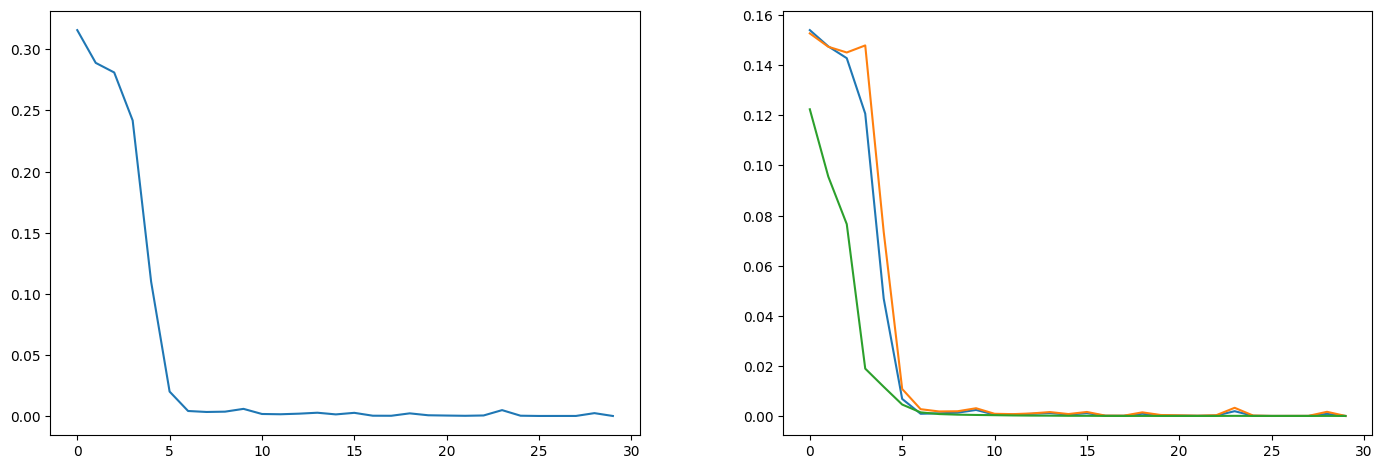

In [39]:
f = plt.figure()
ax = f.subplots(1, 2)
ax[0].plot(epoch_loss_log)
ax[1].plot(epoch_c_log)
f.tight_layout()
f.set_figwidth(15)

Overall MSE
tensor(5.2392e-05)
MSE on jacobian-hessian relation
tensor(1.0630e-05)
MSE on x=0
tensor(0.0002)
MSE on x=1
tensor(1.7636e-05)
MSE on t=0
tensor(4.4612e-05)


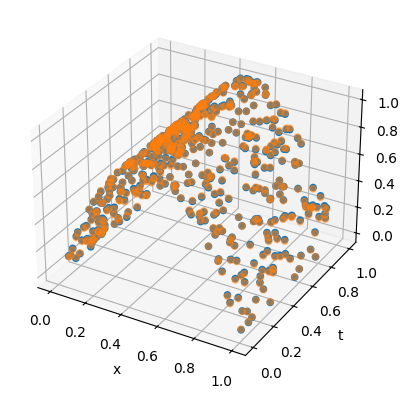

In [41]:
# %matplotlib ipympl


torch.manual_seed(0)
x = torch.rand(500).requires_grad_()
t = torch.rand(500).requires_grad_()
preds = model(torch.vstack((x, t)).T).unbind()
jac_t = torch.autograd.grad(
    outputs=preds,
    inputs=t,
    grad_outputs=None,
    create_graph=True,
    materialize_grads=True,
)[0]
hess_x = torch.autograd.grad(
    outputs=jac_x.unbind(), inputs=x, create_graph=True, materialize_grads=True
)[0]
loss_d = torch.nn.functional.mse_loss(jac_t, alpha * hess_x).detach()

with torch.inference_mode():
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    print("Overall MSE")
    print(torch.nn.functional.mse_loss(preds, _u))
    print("MSE on jacobian-hessian relation")
    print(loss_d)
    print("MSE on x=0")
    print(
        torch.nn.functional.mse_loss(
            model(torch.vstack((torch.zeros_like(t), t)).T).squeeze(),
            torch.zeros_like(preds),
        )
    )
    print("MSE on x=1")
    print(
        torch.nn.functional.mse_loss(
            model(torch.vstack((torch.ones_like(t), t)).T).squeeze(),
            torch.zeros_like(preds),
        )
    )
    print("MSE on t=0")
    print(
        torch.nn.functional.mse_loss(
            model(torch.vstack((x, torch.zeros_like(x))).T).squeeze(),
            torch.sin(torch.pi * x),
        )
    )

    ax = plt.figure().add_subplot(projection="3d")
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds, alpha=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u")

***

In [10]:
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [24]:
# from humancompatible.train.optim import SSLALM, SSLALM_Adam
from torch.optim import Adam
from humancompatible.train.dual_optim import ALM

model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1),
)

constraints = [
    lambda _, t: torch.nn.functional.mse_loss(
        model(torch.vstack((torch.zeros_like(t), t)).T),
        torch.zeros_like(t).unsqueeze(1),
    ),
    lambda _, t: torch.nn.functional.mse_loss(
        model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)
    ),
    lambda x, _: torch.nn.functional.mse_loss(
        model(torch.vstack((x, torch.zeros_like(x))).T),
        torch.sin(torch.pi * x).unsqueeze(1),
    ),
]
m = len(constraints)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
dual_opt = ALM(m=3)

In [25]:
epochs = 30
mse_loss = torch.nn.MSELoss()
epoch_loss_log = []
epoch_c_log = []

for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x, t, y in loader:
        y_hat = model(torch.vstack((x, t)).T)

        cs = []
        for j, constraint in enumerate(constraints):
            c = constraint(x, t)
            cs.append(c.unsqueeze(0))

        cs = torch.cat(cs)
        c_log.append(cs.detach().numpy())

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True,
        )[0]

        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True,
        )[0]

        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(), inputs=x, create_graph=True, materialize_grads=True
        )[0]

        loss_d = mse_loss(jac_t, alpha * hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred
        lagrangian = dual_opt.forward_update(loss, cs)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_log.append(loss.detach().numpy())

    print(sum(loss_log) / len(loss_log))
    epoch_loss_log.append(sum(loss_log) / len(loss_log))
    print(sum(c_log) / len(c_log))
    epoch_c_log.append(sum(c_log) / len(c_log))

0.11290325
[0.39511767 0.39465636 0.11388352]
0.09855075
[0.39316565 0.3930437  0.0981169 ]
0.09796415
[0.3931388  0.392992   0.09776555]
0.09764285
[0.39820623 0.39898837 0.09778892]
0.097871825
[0.3933106  0.40092707 0.09457056]
0.0972846
[0.3731796  0.41310295 0.09074049]
0.09133758
[0.29466328 0.43986243 0.07545112]
0.07661227
[0.14484827 0.46656895 0.03319671]
0.07154362
[0.12820823 0.42081165 0.02229194]
0.04859055
[0.0523439  0.26112133 0.01853894]
0.027703186
[0.02631799 0.14923188 0.00963243]
0.0079941135
[0.00304754 0.05218955 0.0028059 ]
0.004940393
[0.00633425 0.03192712 0.00158514]
0.0019274496
[0.00621325 0.01075072 0.00081534]
0.0043588006
[0.00646698 0.01483956 0.00031845]
0.0018308281
[0.00446054 0.00816088 0.00024073]
0.00036873
[0.00328142 0.00194305 0.00021513]
0.00023723205
[0.00221506 0.00111994 0.00013802]
0.00034795498
[1.6813397e-03 1.3859256e-03 8.5041116e-05]
0.00015566197
[1.3691542e-03 7.8245596e-04 6.5150562e-05]
0.00014081442
[9.9448801e-04 6.9727667e-04 

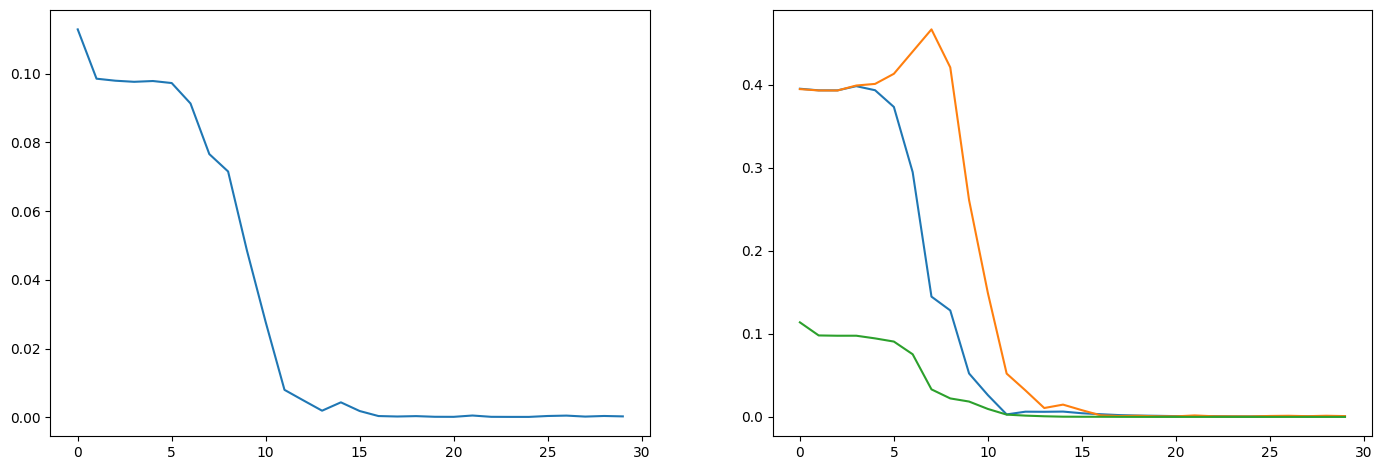

In [26]:
f = plt.figure()
ax = f.subplots(1, 2)
ax[0].plot(epoch_loss_log)
ax[1].plot(epoch_c_log)
f.tight_layout()
f.set_figwidth(15)

In [27]:
dual_opt.duals

tensor([1.2142, 1.7060, 0.3035])

Overall MSE
tensor(6.3661e-05)
MSE on jacobian-hessian relation
tensor(1.6535e-06)
MSE on x=0
tensor(2.3061e-06)
MSE on x=1
tensor(4.0823e-06)
MSE on t=0
tensor(5.9352e-05)


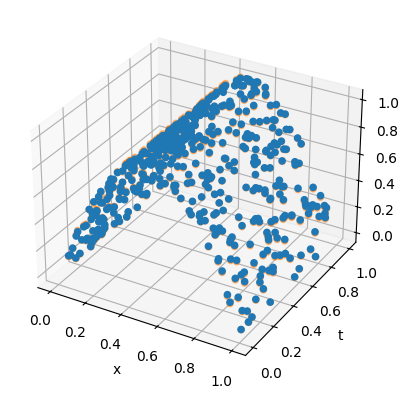

In [28]:
# %matplotlib ipympl


torch.manual_seed(0)
x = torch.rand(500).requires_grad_()
t = torch.rand(500).requires_grad_()
preds = model(torch.vstack((x, t)).T).unbind()
jac_t = torch.autograd.grad(
    outputs=preds,
    inputs=t,
    grad_outputs=None,
    create_graph=True,
    materialize_grads=True,
)[0]
hess_x = torch.autograd.grad(
    outputs=jac_x.unbind(), inputs=x, create_graph=True, materialize_grads=True
)[0]
loss_d = torch.nn.functional.mse_loss(jac_t, alpha * hess_x).detach()

with torch.inference_mode():
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    print("Overall MSE")
    print(torch.nn.functional.mse_loss(preds, _u))
    print("MSE on jacobian-hessian relation")
    print(loss_d)
    print("MSE on x=0")
    print(
        torch.nn.functional.mse_loss(
            model(torch.vstack((torch.zeros_like(t), t)).T).squeeze(),
            torch.zeros_like(preds),
        )
    )
    print("MSE on x=1")
    print(
        torch.nn.functional.mse_loss(
            model(torch.vstack((torch.ones_like(t), t)).T).squeeze(),
            torch.zeros_like(preds),
        )
    )
    print("MSE on t=0")
    print(
        torch.nn.functional.mse_loss(
            model(torch.vstack((x, torch.zeros_like(x))).T).squeeze(),
            torch.sin(torch.pi * x),
        )
    )

    ax = plt.figure().add_subplot(projection="3d")
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds, alpha=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u")